In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
fontsize = 18
figsize = (8, 6)
import seaborn as sns
sns.set_context("talk")
import liboptpy.unconstr_solvers as solvers
import liboptpy.step_size as ss
import liboptpy.restarts as restarts
import scipy.optimize as scopt
import cvxpy

## Quadratic convex functions

### Matrix with high condition number and uniform distributed spectrum

Condition number = 50.000000000000725


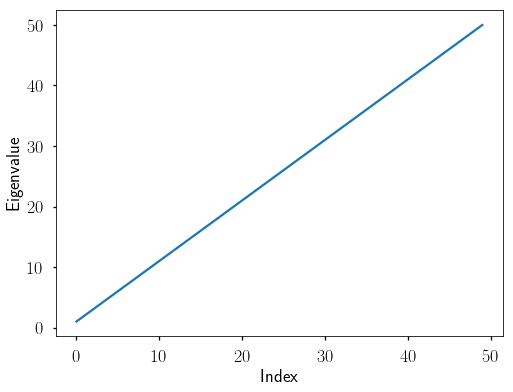

In [2]:
n = 50
D = np.arange(1, n+1)
U = np.random.randn(n, n)
U, _ = np.linalg.qr(U)
A = U.dot(np.diag(D)).dot(U.T)
b = np.random.randn(n)
eig_vals = np.linalg.eigvals(A)
print("Condition number = {}".format(np.max(eig_vals) / np.min(eig_vals)))
plt.figure(figsize=figsize)
plt.plot(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [3]:
f = lambda x: 0.5 * x.T.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
hess_f = lambda x: A

In [4]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(2e-2))
    }

In [5]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [6]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Function value = -2.486833357822711
Norm of gradient = 0.04026385681229745
	 Newton
Convergence in 1 iterations
Function value = -2.487192392778245
Norm of gradient = 4.5223010259911616e-14
	 CG quad
Convergence in 35 iterations
Function value = -2.4871923927782236
Norm of gradient = 6.253292952189007e-07
	 CG FR
Convergence in 75 iterations
Function value = -2.4871923927782404
Norm of gradient = 5.345730000150367e-07
	 BB 1
Convergence in 64 iterations
Function value = -2.4871923927782262
Norm of gradient = 6.510558443728225e-07
	 Nesterov
Convergence in 100 iterations
Function value = -2.487191714522191
Norm of gradient = 0.0011720394344215805


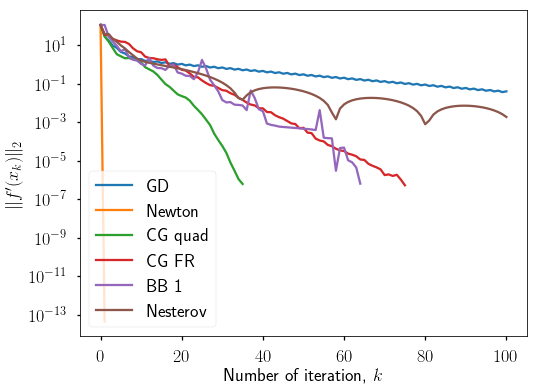

In [7]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=18)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [8]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
1.9 ms ± 82.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Newton
57.2 µs ± 1.86 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG quad
758 µs ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 CG FR
6.04 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 BB 1
1.19 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
	 Nesterov
1.98 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Matrix with high condition number and clusterized spectrum

Condition number = 1000.0000000002618


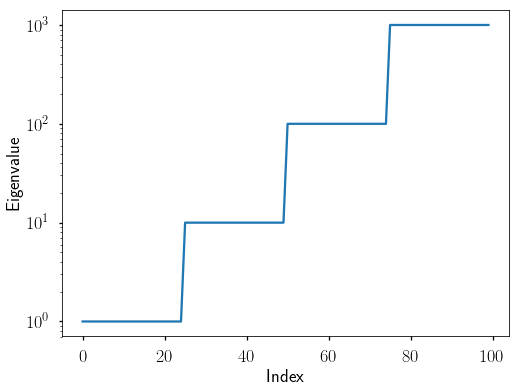

In [8]:
n = 100
A = np.diagflat([np.ones(n//4), 10 * np.ones(n//4), 100*np.ones(n//4), 1000* np.ones(n//4)])
U = np.random.rand(n, n)
Q, _ = np.linalg.qr(U)
A = Q.dot(A).dot(Q.T)
A = (A + A.T) * 0.5
b = np.random.randn(n)
eig_vals = np.linalg.eigvalsh(A)
print("Condition number = {}".format(max(eig_vals) / min(eig_vals)))
plt.figure(figsize=figsize)
plt.semilogy(np.sort(eig_vals))
plt.xlabel("Index", fontsize=fontsize)
plt.ylabel("Eigenvalue", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [9]:
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad_f = lambda x: A.dot(x) - b
x0 = np.zeros(n)

In [14]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.ExactLineSearch4Quad(A, b)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.ExactLineSearch4Quad(A, b)),
     "CG quad": solvers.fo.ConjugateGradientQuad(A, b),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Wolfe strong", rho=0.5, beta1=0.1, beta2=0.7,
                                                                     init_alpha=1.), restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-3))
    }

In [15]:
x0 = np.random.rand(n)
tol = 1e-6
max_iter = 100

In [16]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 100 iterations
Norm of gradient = 14.391726624163997
Function value = -10.178871752968067
	 Newton
Convergence in 1 iterations
Norm of gradient = 1.3463382520129175e-12
Function value = -16.80631256864952
	 CG quad
Convergence in 4 iterations
Norm of gradient = 9.484709087449473e-07
Function value = -16.80631256864967
	 CG FR
Convergence in 100 iterations
Norm of gradient = 1.3269317683848345
Function value = -16.632020352606595
	 BB 1
Convergence in 45 iterations
Norm of gradient = 7.844388818526486e-07
Function value = -16.806312568650007
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 2.871427585204892
Function value = -12.704096034338365


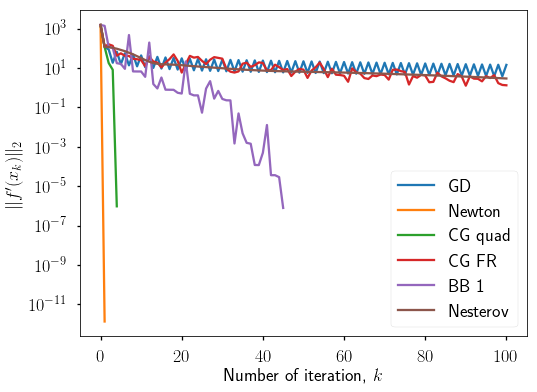

In [17]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
    plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [15]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
3.38 ms ± 454 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Newton
246 µs ± 56.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG quad
179 µs ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
	 CG FR
30.5 ms ± 7.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
2.61 ms ± 68.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov
2.92 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Analytical center of the set of inequalities

In [28]:
n = 100
m = 500
A = np.random.rand(n, m) * 10

In [29]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), \
                          axis=1) + 2 * x / (1 - np.power(x, 2))

hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

In [30]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-4))
    }

In [31]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [32]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 27 iterations
Norm of gradient = 2.688278008402773e-06
Function value = -2898.3365279740356
	 Newton
Convergence in 12 iterations
Norm of gradient = 1.3466081387795514e-09
Function value = -2898.3365279740356
	 CG FR


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Convergence in 35 iterations
Norm of gradient = 4.918724982378915e-06
Function value = -2898.336527974035
	 BB 1
Convergence in 13 iterations
Norm of gradient = 5.889942530872809e-06
Function value = -2898.336527974035
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 13.285459756578138
Function value = -2896.910857175301


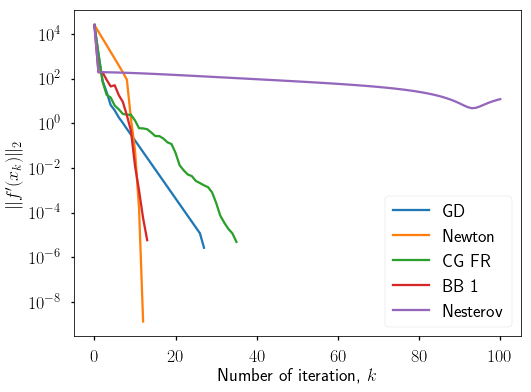

In [33]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [22]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


625 ms ± 71.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 Newton
841 ms ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 CG FR


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


289 ms ± 45.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
	 BB 1
84.6 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Nesterov
906 ms ± 90.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Toy logistic regression with L2 regularization

In [34]:
import numpy as np
import sklearn.datasets as skldata
import scipy.special as scspec

n = 300
m = 1000

X, y = skldata.make_classification(n_classes=2, n_features=n, n_samples=m, n_informative=n//3)
C = 1

def f(w):
    return np.linalg.norm(w)**2 / 2 +  C * np.mean(np.logaddexp(np.zeros(X.shape[0]), -y * X.dot(w)))

def grad_f(w):
    denom = scspec.expit(-y * X.dot(w))
    return w - C * X.T.dot(y * denom) / X.shape[0]

def hess_f(w):
    denom = scspec.expit(-y * X.dot(w))
    d = y**2 * denom**2
    return np.eye(n) + C * (X.T * d).dot(X) / X.shape[0]

x0 = np.zeros(n)
print("Initial function value = {}".format(f(x0)))
print("Initial gradient norm = {}".format(np.linalg.norm(grad_f(x0))))

Initial function value = 0.6931471805599454
Initial gradient norm = 2.001648633529506


In [35]:
m_dict = {
     "GD": solvers.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "Newton": solvers.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.)),
     "CG FR": solvers.fo.ConjugateGradientFR(f, grad_f, ss.Backtracking("Armijo", beta=0.1, rho=0.5, init_alpha=1.), 
                                             restarts.Restart(10)),
     "BB 1": solvers.fo.BarzilaiBorweinMethod(f, grad_f, init_alpha=1e-4, type=1),
     "Nesterov": solvers.fo.AcceleratedGD(f, grad_f, ss.ConstantStepSize(1e-2)),
    }

In [36]:
x0 = np.zeros(n)
tol = 1e-5
max_iter = 100

In [37]:
for key in m_dict:
    print("\t {}".format(key))
    _ = m_dict[key].solve(x0, max_iter, tol, disp=True)

	 GD
Convergence in 86 iterations
Norm of gradient = 9.42500777726752e-06
Function value = 0.4903726170728532
	 Newton
Convergence in 26 iterations
Norm of gradient = 7.4508235299228305e-06
Function value = 0.49037261705694973
	 CG FR
Convergence in 52 iterations
Norm of gradient = 4.589521663847208e-06
Function value = 0.4903726170582446
	 BB 1
Convergence in 51 iterations
Norm of gradient = 4.5925943328101905e-06
Function value = 0.49037261705779356
	 Nesterov
Convergence in 100 iterations
Norm of gradient = 0.0009350952326148085
Function value = 0.49037287066127194


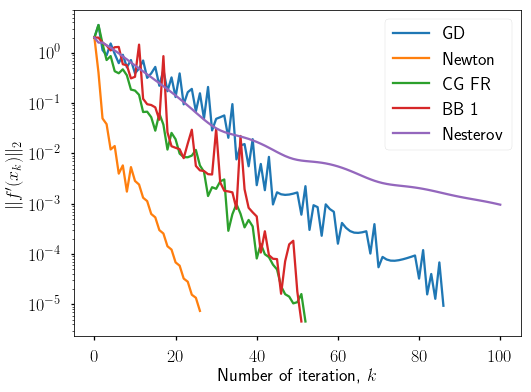

In [38]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([np.linalg.norm(grad_f(x)) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [42]:
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 GD
114 ms ± 9.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Newton
72.3 ms ± 5.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 CG FR
60.9 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 BB 1
6.96 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
	 Nesterov
14.5 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Non-smooth optimization
### Toy SVM classifier

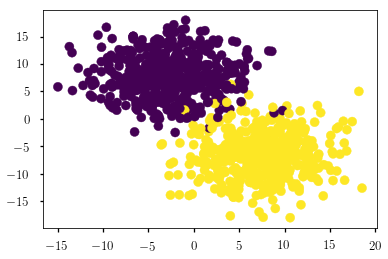

In [12]:
import sklearn.datasets as skldata
n = 2
m = 1000
C = 1
X, y = skldata.make_blobs(n_features=n, n_samples=m, centers=2, cluster_std=4)
y = 2 * y - 1
plt.scatter(X[:, 0], X[:, 1], c=y)

### CVXPy solver

In [30]:
tol = 1e-5
max_iter = 300

In [31]:
w = cvxpy.Variable(n)
b = cvxpy.Variable()
obj = 0.5 * cvxpy.norm2(w)**2 + C * cvxpy.sum_entries(cvxpy.max_elemwise(0, 1 - cvxpy.mul_elemwise(y, (X * w - b))))
problem = cvxpy.Problem(cvxpy.Minimize(obj))
problem.solve(solver="SCS", max_iters=max_iter, eps=tol, verbose=False)
b = b.value
w = np.array(w.value)
print("Optimal objective = {}".format(obj.value))
print("Train accuracy = {}".format(np.mean(y == np.sign(X.dot(w) - b).ravel())))

Optimal objective = 37.527176156779475
Train accuracy = 0.988


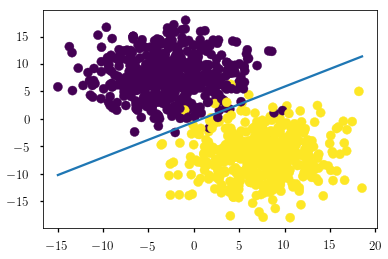

In [32]:
plt.scatter(X[:, 0], X[:, 1], c=y)
x = np.linspace(min(X[:, 0]), max(X[:, 0]))
plt.plot(x, (b - w[0] * x) / w[1])

In [33]:
def hinge_loss(w, X, y, C):
    return 0.5 * np.linalg.norm(w)**2 + C * np.sum(np.maximum(0, 1 - y * X.dot(w)))

def subgrad_hinge_loss(w, X, y, C):
    nnz = 1 - y * X.dot(w)
    subgrad_part = X * y[:, np.newaxis]
    return w - C * np.sum(subgrad_part[nnz > 0], axis=0)

X_ones = np.hstack((X, np.ones((m, 1))))
f = lambda x: hinge_loss(x, X_ones, y, C)
subgrad = lambda x: subgrad_hinge_loss(x, X_ones, y, C)

In [34]:
m_dict = {"Subgrad method": solvers.fo.SubgradientMethod(f, subgrad, ss.InvIterStepSize()),
         }

In [35]:
x0 = np.random.randn(n+1)

In [36]:
for key in m_dict:
    print("\t {}".format(key))
    x = m_dict[key].solve(x0, max_iter, tol, disp=True)
    print("Train accuracy = {}".format(np.mean(y == np.sign(X_ones.dot(x)))))

	 Subgrad method
Convergence in 300 iterations
Function value = 37.837169951024705
Train accuracy = 0.987


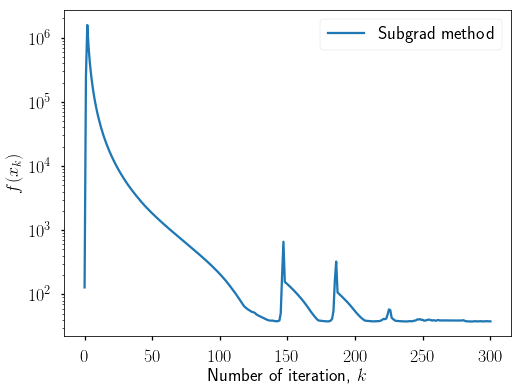

In [37]:
plt.figure(figsize=figsize)
for key in m_dict:
    plt.semilogy([f(x) for x in m_dict[key].get_convergence()], label=key)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$f(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

In [40]:
print("\t SCS CVXPy")
%timeit problem.solve(solver="SCS", max_iters=max_iter, eps=tol, verbose=False)
for key in m_dict:
    print("\t {}".format(key))
    %timeit m_dict[key].solve(x0, max_iter, tol)

	 SCS CVXPy
38.4 ms ± 946 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
	 Subgrad method
11.6 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
